# FEV vs. Alpha Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.mouse import CortexlabMouse
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed, GLOBAL_SEED
from cortexlib.utils.plotting import vgg19_colours
from sklearn.decomposition import PCA
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:53:46 | INFO     | ℹ️ This notebook is running for mouse m02_d3


In [3]:
neural_plae = PowerLawAlphaEstimator()
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons in mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

neural_alpha = neural_plae.compute_alpha(neural_responses_mean)

16:53:46 | INFO     | ⏳ Computing null distributions for all neurons in mouse m02_d3...
16:54:15 | SUCCESS  | ✅ Null distributions computed!
16:54:16 | INFO     | ℹ️ Neural responses shape: (1585, 2, 500)


In [4]:
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
4,conv2_2,100.0,0.016430,0.110485
5,conv3_4,NaN,0.014846,0.104921
10,conv4_4,NaN,0.014912,0.132074
15,conv5_4,NaN,0.009110,0.100818
20,fc2,NaN,0.008360,0.099842


In [5]:
vgg19_data = futils.load_model_features(futils.Model.VGG19, MOUSE_ID)
vgg19_feats = vgg19_data['features']

16:54:16 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m02_d3/_model_features/vgg19_features_mouse_m02_d3.pt


In [6]:
# Save explained variance info

num_components = 128
plot_components = 128
thresholds = [0.80, 0.90]

raw_features = vgg19_feats
layer_names = list(raw_features.keys())
rand_feat_indices = torch.randperm(num_components)[:num_components]

def run_pca(data, n_components=num_components):
    pca = PCA(n_components=n_components, random_state=GLOBAL_SEED)
    pca.fit(data)
    return np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_ratio_

def num_components_for_variance(cumulative_ev, threshold):
    return np.argmax(cumulative_ev >= threshold) + 1

def subsample_features(feats, indices):
    if feats.ndim > 2:
        feats = feats.reshape(feats.shape[0], -1)
    return feats[:, indices] if feats.shape[1] >= len(indices) else feats

features = {
    name: subsample_features(raw_features[name], rand_feat_indices) for name in layer_names
}
features['neural'] = neural_responses_mean[:, rand_feat_indices]

cumulative_ev = {}
ev = {}
for name, feats in features.items():
    cumulative_ev[name], ev[name] = run_pca(feats)

components_needed = {
    t: {name: num_components_for_variance(cumulative_ev[name], t) for name in features}
    for t in thresholds
}

json_data = [
    {
        "mouse_id": MOUSE_ID,
        "model": futils.get_model(),
        "layer": layer,
        "num_principal_components_80pc_ev": int(components_needed[0.80][layer]),
        "num_principal_components_90pc_ev": int(components_needed[0.90][layer]),
        "cumulative_ev": cumulative_ev[layer].tolist(),
    }
    for layer in layer_names
]

futils.write_json_file(json_data, './explained_variance.json')

In [7]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for VGG19 features across layers")
for layer, feats in tqdm(vgg19_feats.items(), desc="α for all VGG19 layers"):
    logger.progress(f"VGG19 {layer}")
    
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha(feats)

    alpha_results.append({
        'layer': layer,
        'alpha': alpha['alpha'],
        'alpha_no_pc1': alpha['alpha_no_pc1'],
    })

logger.success(f"Alphas computed")

16:54:16 | INFO     | ⏳ Computing α for VGG19 features across layers...


α for all VGG19 layers:   0%|          | 0/5 [00:00<?, ?it/s]

16:54:16 | INFO     | ⏳ VGG19 conv2_2...
16:54:16 | INFO     | ⏳ VGG19 conv3_4...
16:54:16 | INFO     | ⏳ VGG19 conv4_4...


16:54:16 | INFO     | ⏳ VGG19 conv5_4...
16:54:16 | INFO     | ⏳ VGG19 fc2...


16:54:18 | SUCCESS  | ✅ Alphas computed!


In [8]:
futils.write_json_file(alpha_results, './dimensionality.json')

In [9]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,conv2_2,1.394331,1.418310
1,conv3_4,1.524415,1.541573
2,conv4_4,1.626546,1.663550
3,conv5_4,1.677220,1.709405
4,fc2,1.592539,1.602094


In [10]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,conv2_2,100.0,0.016430,0.110485,1.394331,1.418310
1,conv3_4,NaN,0.014846,0.104921,1.524415,1.541573
2,conv4_4,NaN,0.014912,0.132074,1.626546,1.663550
3,conv5_4,NaN,0.009110,0.100818,1.677220,1.709405
4,fc2,NaN,0.008360,0.099842,1.592539,1.602094


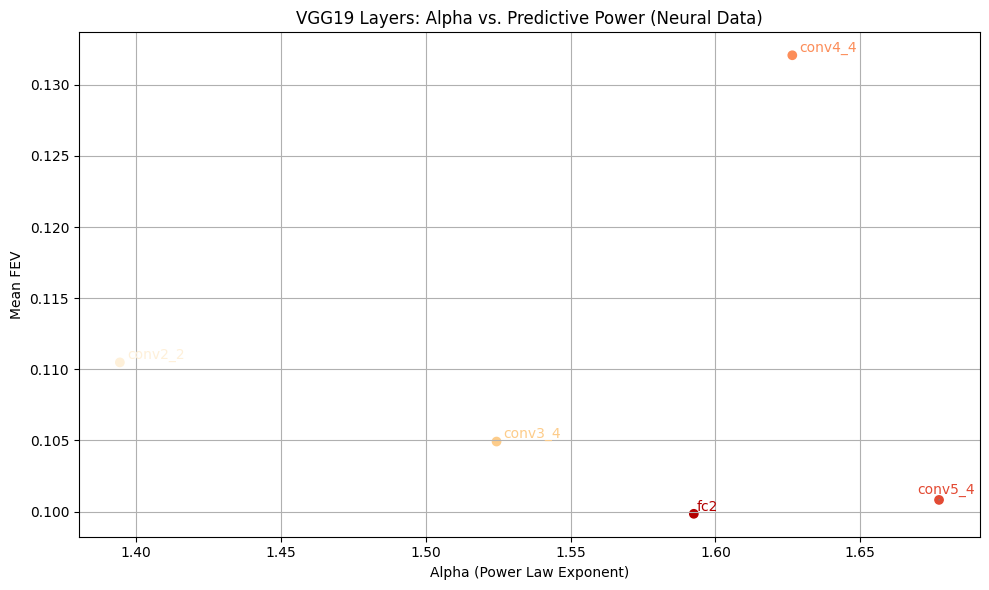

In [11]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: Alpha vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()